In [123]:
from helpers import *
from scipy import stats
import plotly.express as px
import pandas as pd
import seaborn as sns
import bornly as bx
import torch
from torch import nn
device = torch.device("cuda:0")

## Just some exploration

In [2]:
#pip install gym[classic_control]

In [3]:
num_episodes=1000
num_step=200

In [4]:
class HeuristicPendulumAgent:
    def __init__(self, env,torque=1):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.torque=torque
    def compute_action(self, state):
        
       
        if state[1]<1/np.sqrt(2):
            if state[2]>0:
                return self.torque
            else: 
                return -self.torque
        else:
            if state[2]>0:
                return -self.torque
            else:
                return self.torque

In [212]:
# Create the Pendulum environment
env = NormalizedEnv(gym.make('Pendulum-v1',render_mode="human"))
#agent = RandomAgent(env)
agent= HeuristicPendulumAgent(env,0.6)
# Set the environment to the initial state
state = env.reset()
average_total_reward = 0
# Run the simulation for 10 time steps
for e in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    for t in range(num_step):
        # Render the environment
        env.render()

        # Take a random action
        action = agent.compute_action(state)
        next_state, reward, terminated, truncated , info = env.step(action)
        state = next_state
        total_reward += reward
    # Close the environment
    average_total_reward+=total_reward/num_episodes
env.close()

KeyboardInterrupt: 

In [213]:
import pygame
pygame.display.quit()
pygame.quit()

In [214]:
state

array([-0.9742619 ,  0.22541906, -8.        ], dtype=float32)

## Comparaison between random agent and heuristic agent

In [43]:
# Create the Pendulum environment
env = NormalizedEnv(gym.make('Pendulum-v1'))
agent = RandomAgent(env)

# Set the environment to the initial state
state = env.reset()
RA_list_total_reward = []
# Run the simulation for 10 time steps
for e in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    for t in range(num_step):
        # Render the environment
        env.render()

        # Take a random action
        action = agent.compute_action(state)
        next_state, reward, terminated, truncated , info = env.step(action)
        state = next_state
        total_reward += reward
    # Close the environment
    RA_list_total_reward.append(total_reward)
env.close()

C:\Users\torge\anaconda3\lib\site-packages\gym\envs\classic_control\pendulum.py:167: UserWarning:

WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("Pendulum-v1", render_mode="rgb_array")



In [44]:
# Create the Pendulum environment
env = NormalizedEnv(gym.make('Pendulum-v1'))
agent= HeuristicPendulumAgent(env)

# Set the environment to the initial state
state = env.reset()
HA_list_total_reward = []
# Run the simulation for 10 time steps
for e in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    for t in range(num_step):
        # Render the environment
        env.render()

        # Take a random action
        action = agent.compute_action(state)
        next_state, reward, terminated, truncated , info = env.step(action)
        state = next_state
        total_reward += reward
    # Close the environment
    HA_list_total_reward.append(total_reward)
env.close()

In [45]:
data = list(map(lambda x: ('HA',x),HA_list_total_reward)) + list(map(lambda x: ('RA',x),RA_list_total_reward))

In [46]:
df = pd.DataFrame(data,columns=['policy','total_reward'])

(0.0, -1321.298532416723)

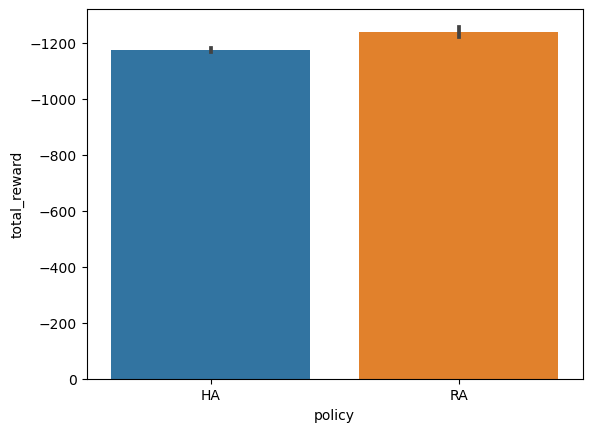

In [47]:
plt = sns.barplot(data=df, x="policy", y="total_reward")
plt.set_ylim(plt.get_ylim()[::-1])


In [48]:
stats.ttest_ind(HA_list_total_reward,RA_list_total_reward,equal_var = False)

Ttest_indResult(statistic=6.524201986811272, pvalue=9.604543800956925e-11)

Running on 1000 episodes the Welch’s t-test shows that the HA gets a better total reward on average that RA

In [51]:
df = pd.DataFrame(columns=['torque', 'total_reward'])

In [52]:
num_episodes=100

In [53]:
# Create the Pendulum environment
env = NormalizedEnv(gym.make('Pendulum-v1'))
agent= HeuristicPendulumAgent(env)

# Set the environment to the initial state
state = env.reset()

# Run the simulation for 10 time steps
average_reward_torque = []
for torque in np.linspace(0.1, 1, num=10):
    average_total_reward = 0
    agent = HeuristicPendulumAgent(env,torque)
    for e in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0
        for t in range(num_step):
            # Render the environment
            env.render()

            # Take a random action
            action = agent.compute_action(state)
            next_state, reward, terminated, truncated , info = env.step(action)
            state = next_state
            total_reward += reward
        # Close the environment
        
        average_total_reward += (total_reward)/num_episodes
        new_row=(torque,total_reward)
        df = pd.concat([df, pd.DataFrame([new_row], columns=df.columns)], ignore_index=True)
    average_reward_torque.append(average_total_reward)
env.close()

C:\Users\torge\anaconda3\lib\site-packages\gym\envs\classic_control\pendulum.py:167: UserWarning:

WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("Pendulum-v1", render_mode="rgb_array")



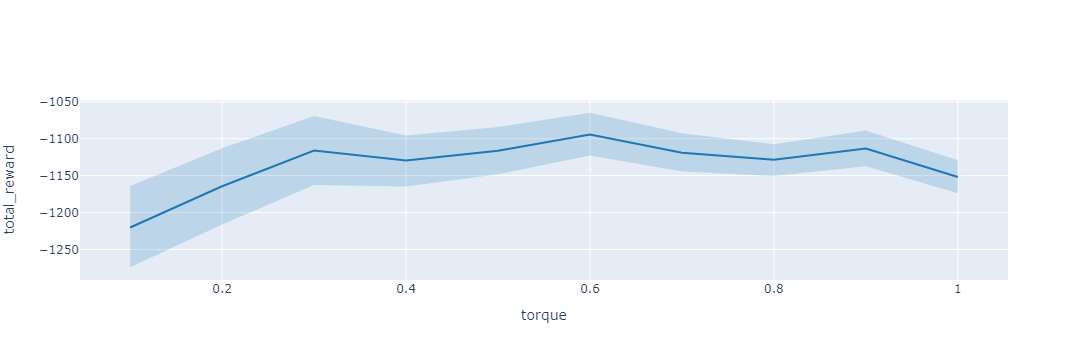

In [59]:
ax = bx.lineplot(data=df, x="torque", y="total_reward")
ax.figure

In [8]:
class Buffer:    
    def __init__(self, capacity=10000,state_dim=3,action_dim=1):
        
        self.capacity = capacity
        
       
        
        self.num_samples = 0

        # followong SARSA we need to store: state ,action ,reward ,next state ,next action
        self.state_tape = torch.zeros((self.capacity, state_dim))
        self.action_tape = torch.zeros((self.capacity, action_dim))
        self.reward_tape = torch.zeros((self.capacity, 1))
        self.next_state_tape = torch.zeros((self.capacity, state_dim))
        self.next_action_tape = torch.zeros((self.capacity, action_dim))
        
    def add(self, sample):
       # sample = (state, action, reward, next_state, next_action)
        #to replace
        index = self.num_samples % self.capacity

        self.state_tape[index] = torch.from_numpy(sample[0])
        self.action_tape[index] = sample[1]
        self.reward_tape[index] = sample[2]
        self.next_state_tape[index] = torch.from_numpy(sample[3])
        self.next_action_tape[index] = sample[4]
        self.num_samples += 1



        
class Qnetwork(nn.Module):
    def __init__(self,state_dim=3,action_dim=1,hidden_dim=32):
        super().__init__()
        self.input_shape = state_dim + action_dim
        self.fc1 = nn.Linear(self.input_shape,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim,1)
        self.activation=nn.ReLU()
    def forward(self,x):
        output = self.fc1(x)
        output = self.activation(output)
        output = self.fc2(output)
        output = self.activation(output)
        output = self.fc3(output)
        return output
        

In [14]:
buffer= Buffer()
# Create the Pendulum environment
env = NormalizedEnv(gym.make('Pendulum-v1'))
#agent = RandomAgent(env)
agent= HeuristicPendulumAgent(env,0.6)
# Set the environment to the initial state
state = env.reset()
average_total_reward = 0
# Run the simulation for 10 time steps
for e in range(100):
    state = env.reset()[0]
    total_reward = 0
    for t in range(100):
        # Render the environment
        env.render()
        temp = state
        # Take a random action
        action = agent.compute_action(state)
        next_state, reward, terminated, truncated , info = env.step(action)
        state = next_state
        total_reward += reward
        next_action = agent.compute_action(next_state)
        sample = (temp,action,reward,next_state,next_action)
        buffer.add(sample)
    # Close the environment
    average_total_reward+=total_reward/num_episodes
env.close()

In [217]:
buffer.state_tape

tensor([[ 0.1946, -0.9809,  0.1088],
        [ 0.1726, -0.9850, -0.4469],
        [ 0.1050, -0.9945, -1.3656],
        ...,
        [ 0.7910,  0.6119, -2.5445],
        [ 0.8551,  0.5185, -2.2656],
        [ 0.9038,  0.4280, -2.0567]])

In [ ]:
def update_average(mparam, tparam,beta):
        
        return tparam * (1-beta) + (beta) * mparam

In [74]:
def EMA(model,target,beta):
    for current_params, ma_params in zip(
            model.parameters(), target.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = update_average(up_weight, old_weight,beta)
    

In [144]:
model = Qnetwork().to(device)
target = Qnetwork().to(device)
for param in target.parameters():
        param.requires_grad = False
EMA(model,target,1)


epochs=1000
batch_size=128
lr=1e-4
beta=0.5
gamma=0.99
loss=torch.nn.MSELoss()
optimizer=torch.optim.SGD(model.parameters(),lr)


In [211]:
10000/128

78.125

In [145]:
from tqdm import tqdm

In [146]:
losses = []
for e in tqdm(range(epochs)):
    epoch_loss = 0
    for index in range(0, buffer.num_samples, batch_size):
        optimizer.zero_grad()
        
        action_batch = buffer.action_tape[index:(index+batch_size)]
        state_batch = buffer.state_tape[index:(index+batch_size)]
        next_action_batch = buffer.next_action_tape[index:(index+batch_size)]
        next_state_batch = buffer.next_state_tape[index:(index+batch_size)]
        reward_batch = buffer.reward_tape[index:(index+batch_size)].to(device)
       
        input_model = torch.cat((state_batch,action_batch),dim=1).to(device)
        input_target = torch.cat((next_state_batch,next_action_batch),dim=1).to(device)
        
        x = model(input_model)
        y = reward_batch + gamma*target(input_target)
       
        l=loss(x,y)
        l.backward()
        optimizer.step()
        epoch_loss += l.item()
        
        EMA(model,target,1)
    losses.append(epoch_loss)
        

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:30<00:00,  6.66it/s]


for p in model.parameters():
    print(p)

In [147]:
len(losses)

1000

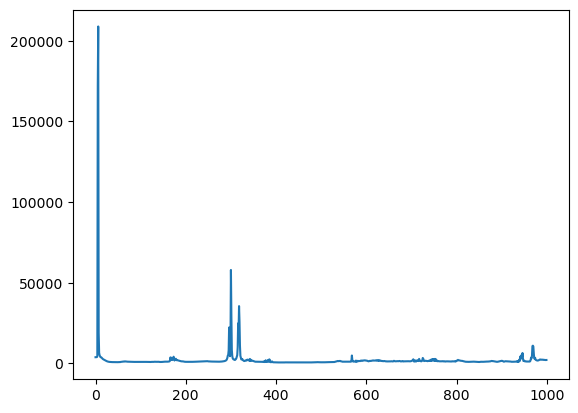

In [148]:
import matplotlib.pyplot as plt
x=list(range(epochs))
y=losses
plt.plot(x,y)

In [ ]:
def polar_heatmap(radius,angle,model,speed,action):
    # Create a figure object and specify the dimensions of the plot
    fig = plt.figure(figsize=(9,9))
    # Creating the axes object
    ax = Axes3D(fig)
    # Creating a meshgrid for the plot
    R, th = np.meshgrid(radius, angle)
    z = np.sin(R)
    # Specifying the projection as polar
    plt.subplot(projection="polar")
    # Defining the colormesh to define the color as per the values
    plt.pcolormesh(th, R, z)
    # PLotting the figure
    plt.plot(angle, R, color='k', ls='none') 
    # Displaying the plot
    plt.show()

In [201]:
pi=torch.acos(torch.zeros(1)).item() * 2
radius = torch.linspace(0, 1, 100)
angle = torch.linspace(0, 2 * pi, 100)
x=torch.cos(angle)
y=torch.sin(angle)
z=torch.zeros(angle.shape[0],radius.shape[0])
average_speed=buffer.state_tape[:,2].mean()
action=0.6
for i in range(x.shape[0]):
    inp = torch.tensor([x[i],y[i],average_speed,action]).to(device)
    # z is constant with respect to the radius
    z[i,:] = model(inp)
angle = angle.detach().numpy()
z = z.detach().numpy()
radius = radius.detach().numpy()

In [182]:
from mpl_toolkits.mplot3d import Axes3D

C:\Users\torge\AppData\Local\Temp\ipykernel_25364\918387216.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
C:\Users\torge\AppData\Local\Temp\ipykernel_25364\918387216.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(th, r, z)


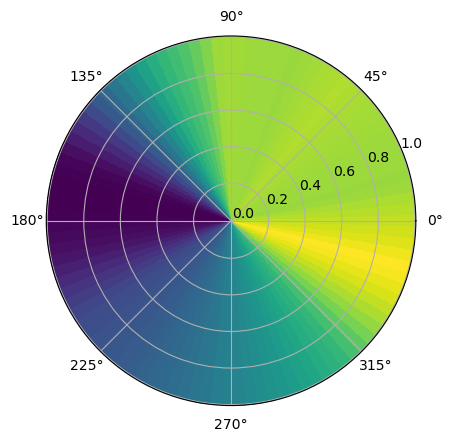

In [203]:
fig = plt.figure()
ax = Axes3D(fig)
r, th = np.meshgrid(radius, angle)
plt.subplot(projection="polar")

plt.pcolormesh(th, r, z)
#plt.pcolormesh(th, z, r)

plt.plot(angle, r, color='k', ls='none') 
plt.grid()

plt.show()

In [204]:
average_speed

tensor(0.7383)

In [205]:
action

0.6

C:\Users\torge\AppData\Local\Temp\ipykernel_25364\553970007.py:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
C:\Users\torge\AppData\Local\Temp\ipykernel_25364\553970007.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(th, r, z)


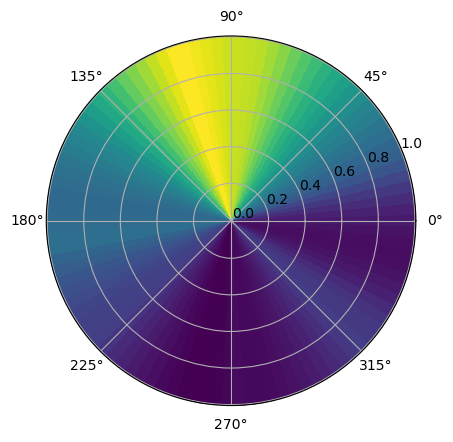

In [210]:
pi=torch.acos(torch.zeros(1)).item() * 2
radius = torch.linspace(0, 1, 100)
angle = torch.linspace(0, 2 * pi, 100)
x=torch.cos(angle)
y=torch.sin(angle)
z=torch.zeros(angle.shape[0],radius.shape[0])
average_speed=-5.0
action=0.6
for i in range(x.shape[0]):
    inp = torch.tensor([x[i],y[i],average_speed,action]).to(device)
    # z is constant with respect to the radius
    z[i,:] = model(inp)
angle = angle.detach().numpy()
z = z.detach().numpy()
radius = radius.detach().numpy()

fig = plt.figure()
ax = Axes3D(fig)
r, th = np.meshgrid(radius, angle)
plt.subplot(projection="polar")

plt.pcolormesh(th, r, z)
#plt.pcolormesh(th, z, r)

plt.plot(angle, r, color='k', ls='none') 
plt.grid()

plt.show()